# Social Network

In [11]:
options(stringsAsFactors=F)
dmatrix = as.matrix(read.csv(url("https://raw.githubusercontent.com/ryanraaum/bioanth-datasets/master/raw/networkgroom.csv"), row.names=1))
dmatrix

,M01,M02,M03,M04,M05,M08,F07,F08,F09,F10,F11,F12,F13,M12,M14,F26,F27,F28,F29
M01,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.07317073,0.00000000,0.24390244,0.02439024,0.46341463,0.14634146,0.00000000,0.00000000,0.21951219,0.04878049,0.02439024,0.00000000
M02,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.17073171,0.00000000,0.00000000,0.00000000,0.00000000,0.02439024,0.17073171,0.02439024,0.02439024
M03,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.1951220,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.2439024,0.0000000,0.0000000,0.6585366,0.1951220,0.0000000,0.5609756
M04,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02439024,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.26829268,0.17073171,0.04878049,0.07317073
M05,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04878049,0.04878049,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02439024,0.07317073
M08,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04878049,0.00000000,0.17073171
F07,0.00000000,0.00000000,0.19512195,0.00000000,0.00000000,0.00000000,0.00000000,0.02439024,0.00000000,0.39024390,0.31707317,0.02439024,0.12195122,0.00000000,0.00000000,0.00000000,0.02439024,0.00000000,0.07317073
F08,0.07317073,0.00000000,0.00000000,0.00000000,0.04878049,0.00000000,0.02439024,0.00000000,0.02439024,0.04878049,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02439024,0.00000000
F09,0.00000000,0.00000000,0.00000000,0.02439024,0.04878049,0.00000000,0.00000000,0.02439024,0.00000000,0.00000000,0.02439024,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
F10,0.24390244,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.39024390,0.04878049,0.00000000,0.00000000,0.19512195,0.39024390,0.09756098,0.02439024,0.00000000,0.09756098,0.04878049,0.00000000,0.14634146


## igraph

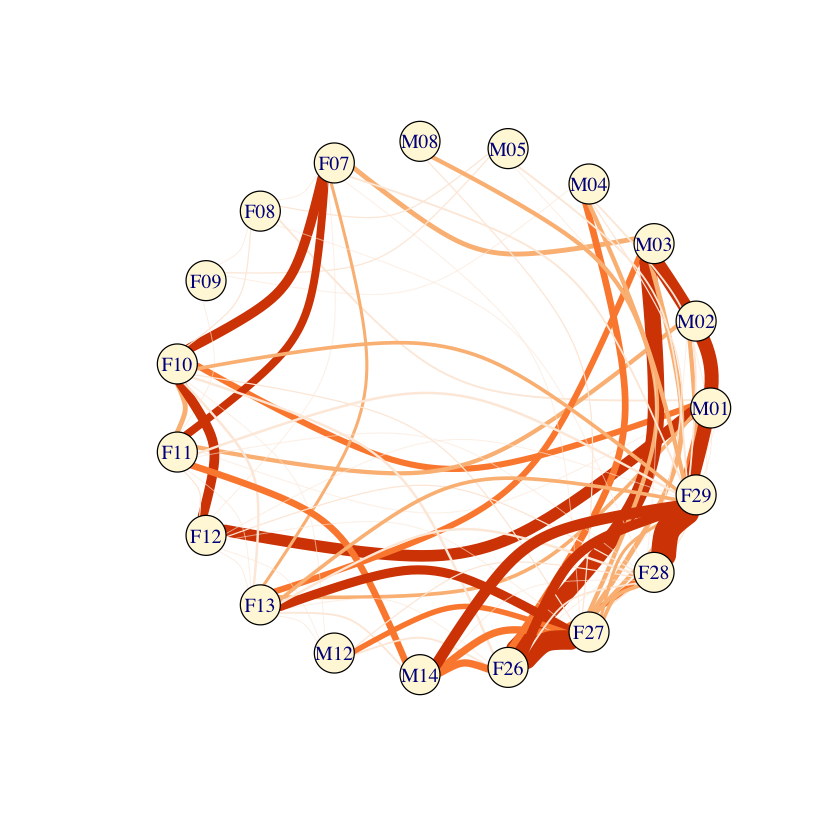

In [12]:
library(igraph)

g = graph.adjacency(dmatrix, mode="undirected", weighted=TRUE)

ecolor_map = function(x) {
    if (x < 0.1) {return("#FDEBDD")}
    else if (x >= 0.1 & x < 0.2) {return("#FBBD84")}
    else if (x >= 0.2 & x < 0.3) {return("#FC8B3B")}
    return("#D74701")
}

ecolors = sapply(E(g)$weight, ecolor_map)

#plot(g, layout=layout_with_fr(g, weight=1/E(g)$weight), 
plot(g, layout=layout_in_circle, 
        edge.width=20*E(g)$weight, 
        edge.curved=T, 
        edge.color=ecolors,
        vertex.color='cornsilk')

## statnet

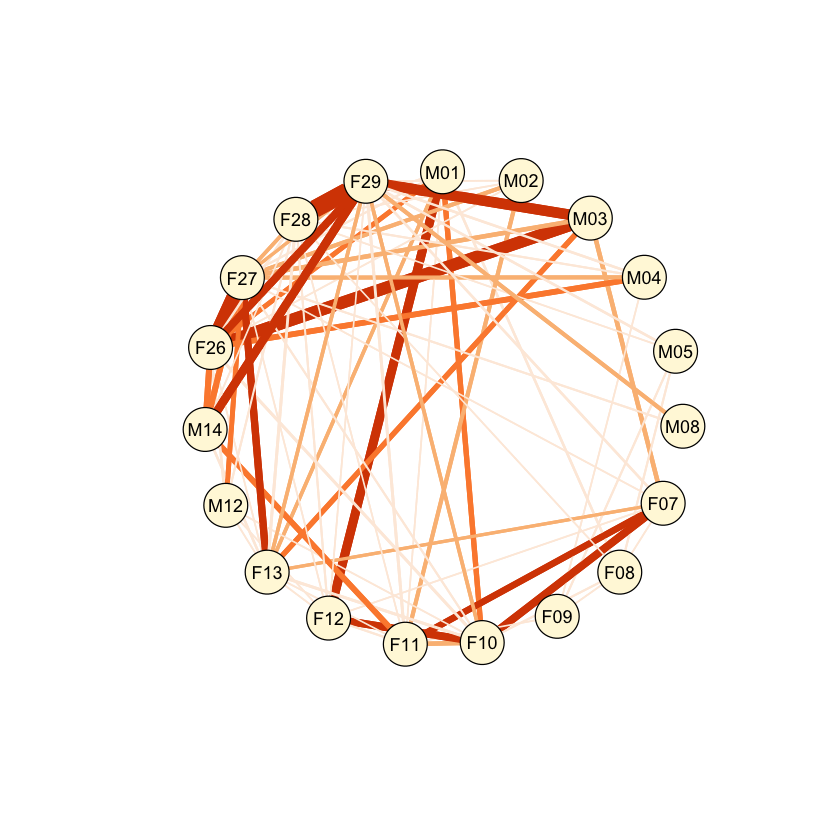

In [13]:
library(network)
library(sna)

net = network(dmatrix, matrix.type="adjacency", directed=F, ignore.eval=FALSE,names.eval="value")

gplot(net, gmode="graph", 
           mode="circle", 
           vertex.cex=2,
           vertex.col='cornsilk',
           label=net %v% 'vertex.names',
           label.pos=5,
           label.cex=0.9,
           edge.lwd=net%e%'value' * 15,
           edge.col=ecolors,
           usecurve=F)

## ggplot2 network plotting

At the moment, there are at least three ggplot2 based network plotting packages: **ggnet**, **ggnetwork**, and **ggraph**. Of these, only **ggnet** is reasonably mature, but may ultimately be the most limited of the batch. **ggnetwork** is on the verge of being broadly usable, but **ggraph** is still bleeding-edge. 

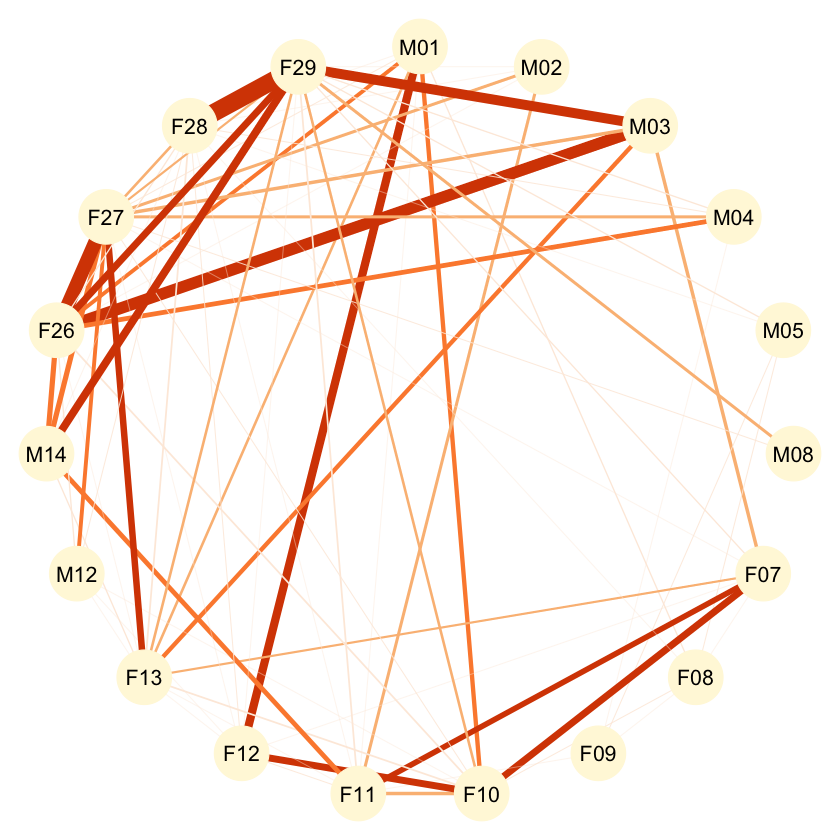

In [14]:
library(network)
library(sna)
library(ggplot2)
library(GGally)

net = network(dmatrix, matrix.type="adjacency", directed=F, ignore.eval=FALSE,names.eval="value")

ggnet2(net, 
       mode="circle",
       color="cornsilk",
       size=15,
       label='vertex.names',
       edge.color=ecolors,
       edge.size=net%e%'value'*5)

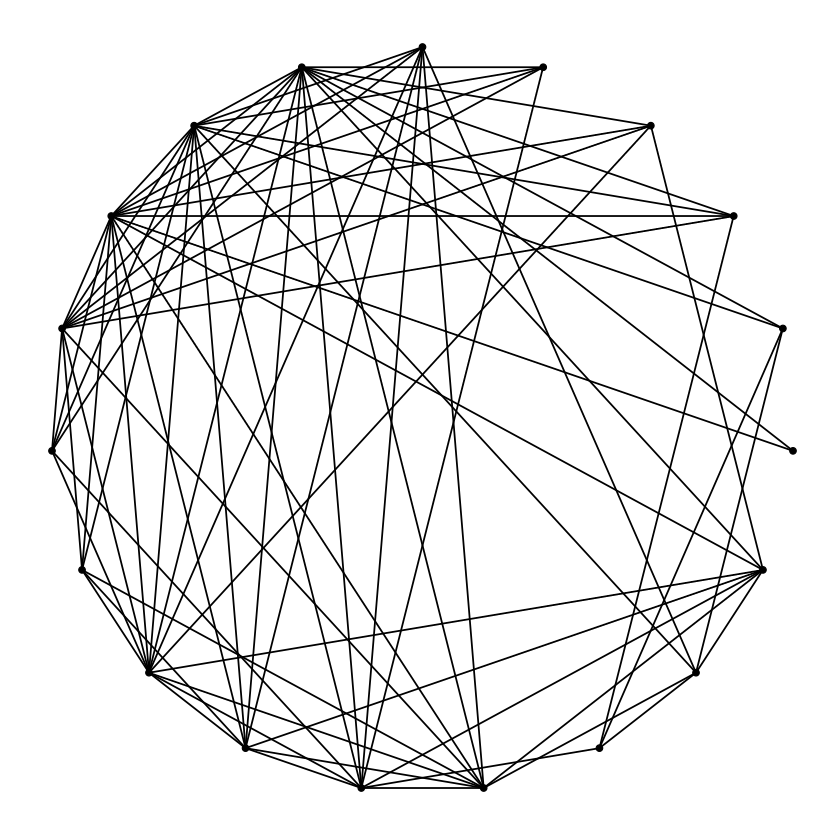

In [18]:
library(ggnetwork) # installed from devtools

g = graph.adjacency(dmatrix, mode="undirected", weighted=TRUE)

ggplot(ggnetwork(g, layout="circle"), aes(x=x, y=y, xend=xend, yend=yend)) +
    geom_edges(color="black") +
    geom_nodes(color="black") +
    theme_blank()

